# Прогнозирование оттока клиентов фитнес-центра

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 

Проблема - отток клиентов.

Источник данных - пользовательские анкеты, приведенные к электронному виду.

Задача — провести анализ и подготовить план действий по удержанию клиентов:
- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами: 
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.

Датасет подготовлен на стороне заказчика.
Он содержат данные о клиентах за месяц до проверки факта оттока и признак факта оттока на определённый месяц. 

## Загрузка данных

In [1]:
# установим библиотеки
!pip install phik

In [2]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
import phik

In [3]:
# откроем и проверим датасет
data = pd.read_csv('/datasets/gym_churn.csv')
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
#Приведем названия столбцов датасета к нижнему регистру
data.columns = data.columns.str.lower()
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Описание полей Датасета:

**Данные клиента за предыдущий до проверки факта оттока месяц:**

*	gender — пол;
*	near_location — проживание или работа в районе, где находится фитнес-центр;
*	partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
*	promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
*	phone — наличие контактного телефона;
*	age — возраст;
*	lifetime — время с момента первого обращения в фитнес-центр (в месяцах).

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**

*	contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
*	month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
*	group_visits — факт посещения групповых занятий;
*	avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
*	avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
*	avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

* **churn — факт оттока в текущем месяце.**


## Исследовательский анализ данных (EDA)

In [5]:
# проверим общую информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Датасет содержит 4000 строк.

Пропуски отсутствуют. Данные в столбцах соответствуют типам данных.


In [6]:
# проверим основные показатели датасета
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Поле **gender** содержит значения от 0 до 1. Среднее значение 0.51, т.е количество мужчин и женщин в выборке примерно одинаково. По имеющимся признакам нет возможности идентифицировать значения признаков 0 и 1.

Поле **near_location** также содержит значение от 0 до 1. 84,5% пользователей проживают или работают неподалеку от спортзала.

Поле **partner** также содержит бинарный признак. 48,67% - сотрудники компании-партнера клуба.

**promo_friends** - бинарный признак. 30% пользователей - приобрели абонимент по рекомендации, в рамках програмы лояльности "Приведи друга".

**phone** - 90% пользователей заполнили свой номер телефона в анкете.

**contract_period** - период действия абонимента составляет от 1 до 12 месяцев. В среднем - 4,6 месяца. 75% пользователей приобрели абонимент на срок менее полугода.

**group_visits** - бинарное поле. 41% пользователей посещают групповые занятия.

**age** - клиенты фитнес-центра - взрослые в возрасте от 18 до 41 года. Средний возраст - 29 лет. 75й процентиль по возрасту - 31 год.

**avg_additional_charges_total** - суммарная выручка от дополнительных услуг центра. Значения варьируются от 0,14 единиц до 552,59 единиц. В среднем посетители фитнес-центра тратят по 146 единиц.

**month_to_end_contract** - срок окончания действующего контракта (в месяцах) составляе от 1 до 12 месяцев. Среднее значение 4,32 месяца

**lifetime** - время с момента первого обращения клиента составляет от 0 до 31 месяцев. Средняя продолжительность взаимодействия - 3,72 месяца, 75-й процентиль - 5 месяцев. 

**avg_class_frequency_total** - средняя частота посещений в неделю за все время *с начала действия абонемента* составляет от 0 до 6. Среднее значение для всех записей - 1,8, 75-й перцентиль - 2,5 посещений в неделю.

**avg_class_frequency_current_month** -  средняя частота посещений в неделю *за предыдущий месяц* составляет от 0 до 6. Среднее значение для всех записей - 1,76, 75-й перцентиль - 2,5 посещений в неделю.

**churn**- признак факта оттока в текущем месяце положителен для 26,5% клиентов.

In [7]:
# проверим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался
churn_mean_pivot = data.groupby(['churn']).agg('mean').round(2).reset_index()
# транспонируем полученные данные
churn_mean_pivot = churn_mean_pivot.T
churn_mean_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, churn to avg_class_frequency_current_month
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       14 non-null     float64
 1   1       14 non-null     float64
dtypes: float64(2)
memory usage: 336.0+ bytes


In [8]:
# переименуем столбцы, удалим первую строку, посчитаем разность показателей средних величин для активных клиентов и ушедших в отток
churn_mean_pivot = churn_mean_pivot.rename(columns = {0: 'Активные клиенты', 1: 'Отток'})
churn_mean_pivot = churn_mean_pivot.drop('churn', axis = 0)


In [9]:
#Сравнение средних значений различных признаков в разрезе признака активности клиентов
churn_mean_pivot ['Разность (Отток - Активные клиенты)'] = churn_mean_pivot ['Отток'] - churn_mean_pivot ['Активные клиенты']
churn_mean_pivot ['Относительная разница, %'] = ((churn_mean_pivot ['Отток'] - churn_mean_pivot ['Активные клиенты'])/churn_mean_pivot ['Активные клиенты'])*100

churn_mean_pivot.sort_values(by = 'Относительная разница, %')

,Активные клиенты,Отток,Разность (Отток - Активные клиенты),"Относительная разница, %"
lifetime,4.71,0.99,-3.72,-78.980892
contract_period,5.75,1.73,-4.02,-69.913043
month_to_end_contract,5.28,1.66,-3.62,-68.560606
avg_class_frequency_current_month,2.03,1.04,-0.99,-48.768473
promo_friends,0.35,0.18,-0.17,-48.571429
group_visits,0.46,0.27,-0.19,-41.304348
partner,0.53,0.36,-0.17,-32.075472
avg_additional_charges_total,158.45,115.08,-43.37,-27.371411
avg_class_frequency_total,2.02,1.47,-0.55,-27.227723
near_location,0.87,0.77,-0.10,-11.494253


Из сводной видно, что наибольшее отличие имеют средние значения по признакам lifetime, contract_period, month_to_end_contract.
Эти признаки могут быть наиболее полезными при решении задачи прогнозтрования оттока клиентов.


Пол и наличие указанного номера телефона никак не изменяются для различных значений признаков churn. 

___

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

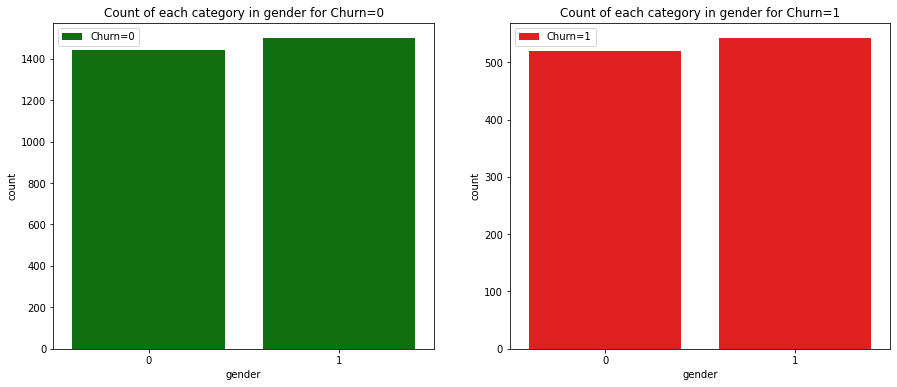

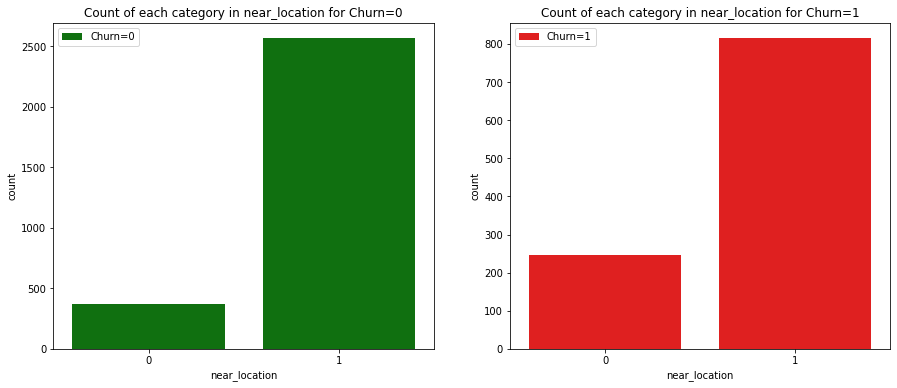

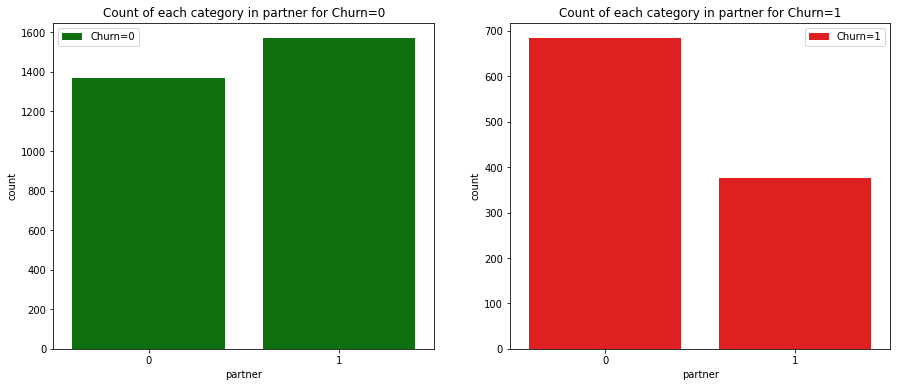

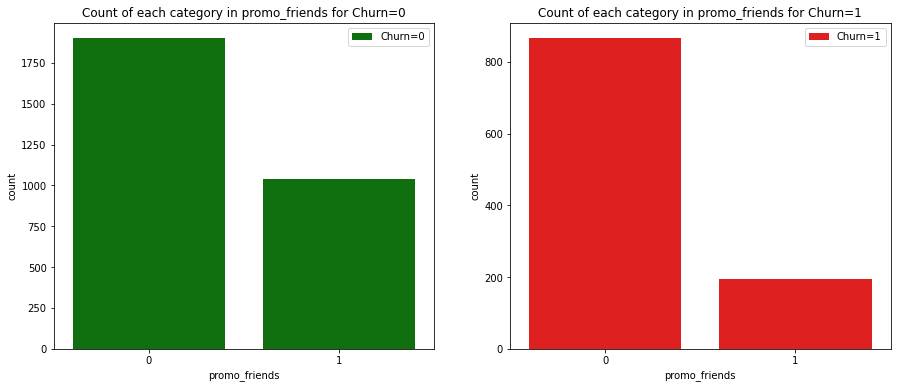

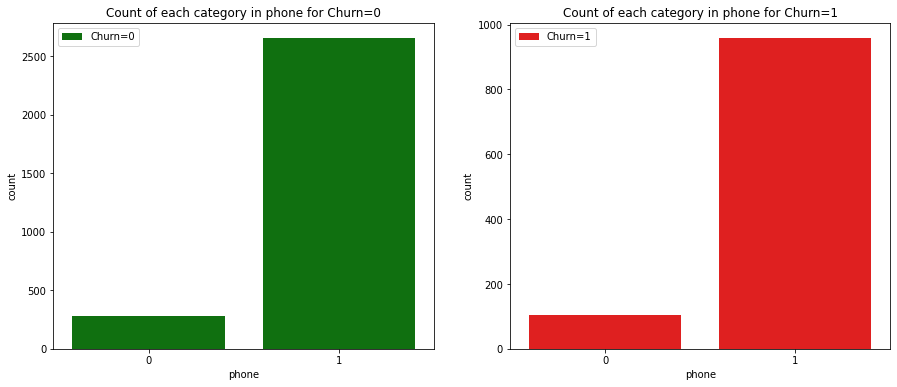

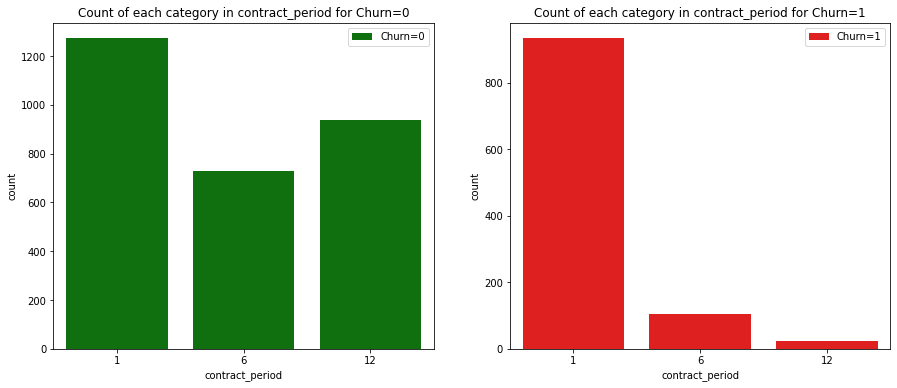

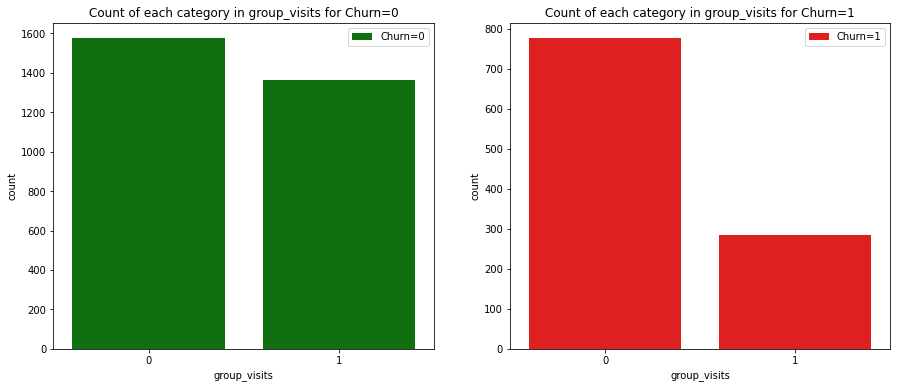

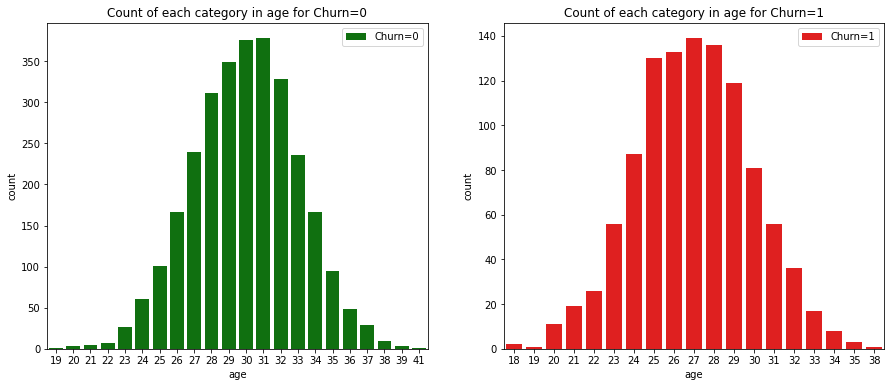

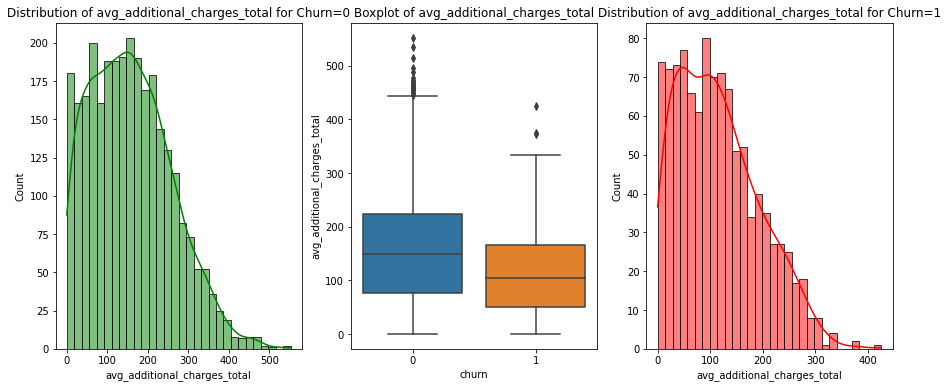

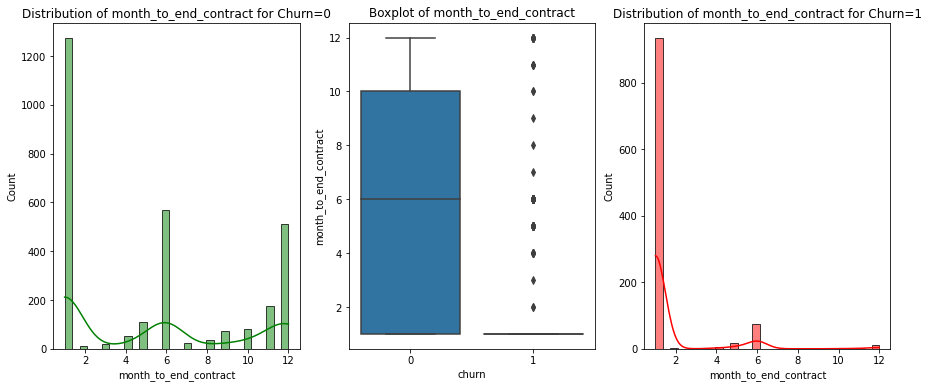

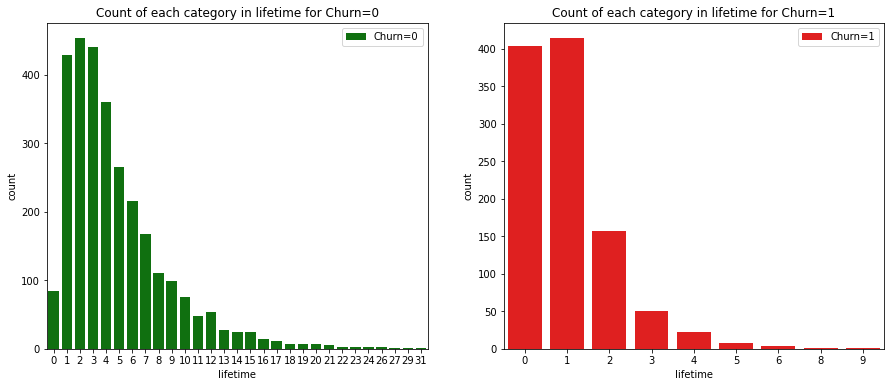

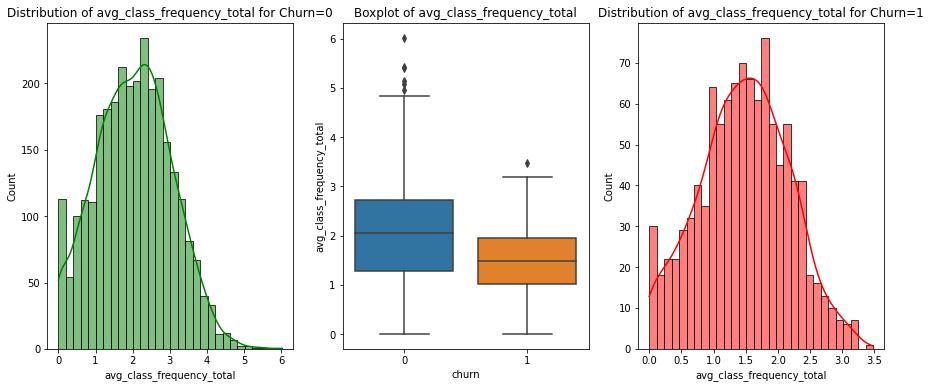

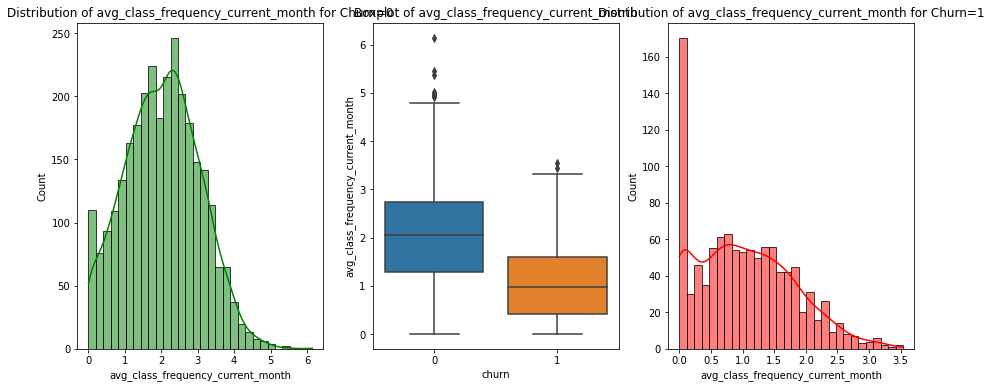

In [10]:
# перезапишем переменную для дальнейшей предобработки с целью запуска алгоритма машиного обучения. 
# исходный датасет оставим неизменым, т.к он может понадобиться в дальнейшем
df = data.copy()

# объявим функцию, которая разделяет переменные на категориальные и непрерывные на основании типа данных.
# на основании полученного деления выведем графики, соответствующие типам неременных

def plot_distribution(df, feature):
    plt.figure(figsize=(15, 6))
    
    if df[feature].dtype == 'float64':
        # Для непрерывных признаков строим гистограмму, boxplot и histplot
        plt.subplot(1, 3, 1)
        sns.histplot(data=df[df['churn'] == 0], x=feature, bins=30, kde=True, color='green')
        plt.title(f'Distribution of {feature} for Churn=0')

        plt.subplot(1, 3, 2)
        sns.boxplot(x='churn', y=feature, data=df)
        plt.title(f'Boxplot of {feature}')

        plt.subplot(1, 3, 3)
        sns.histplot(data=df[df['churn'] == 1], x=feature, bins=30, kde=True, color='red')
        plt.title(f'Distribution of {feature} for Churn=1')
    else:
        # Для категориальных признаков строим столбчатую диаграмму
        plt.subplot(1, 2, 1)
        sns.countplot(data=df[df['churn'] == 0], x=feature, color='green', label='Churn=0')
        plt.title(f'Count of each category in {feature} for Churn=0')
        plt.legend()

        plt.subplot(1, 2, 2)
        sns.countplot(data=df[df['churn'] == 1], x=feature, color='red', label='Churn=1')
        plt.title(f'Count of each category in {feature} for Churn=1')
        plt.legend()
    
    plt.show()

# Получим список признаков
features = df.columns[:-1]  # Исключим последний столбец "Churn"

# Построим графики для каждого признака
for feature in features:
    plot_distribution(df, feature)

Проанализаируем распределения признаков поочередно в разрезе признака Churn:

1) Признаки *gender, near_location, promo_friends, group_visits* - **имеют всего по два возможных значения признаков (0 или 1)**. Разница между ними видна на графике наглядно. Также ее можно увидеть в таблице выше, в которой проводится сравнение средних значений различных признаков в разрезе признака активности клиентов.

Выбросы для данных значений не неблюдается.

2) Рассмотрим распределения признаков, имеющие более двух значений:

- contract_period. Период действия абонимента имеет три воможных варианта длительности: 1, 6 и 12 месяцев.

Для пользователей, попавших в отток, преобладает использование абонимента длительностью в 1 месяц. Возможно, это пользователи, которые приобрели "пробный" абонимент на минимальный возможный срок и не вернулись за продлением. 
Для активных пользователей распределение между различными периодами более равномерно - более половины пользователей имеют абонимент на срок 6 или 12 месяцев.

- age. Возраст пользователей для обеих групп имеет распредение, близкое к нормальному. В целом стабильные пользователи немного старше ушедших в отток - в среднем на 3 года.

- avg_additional_charges_total. Имеет вид правостороннего распределения. На графике не наблюдается сильных выбросов.

- month_to_end_contract. Для активных пользователей признак имеет правостороннее распределение без видимых выбросов. Для пользователей, попавших в отток основное значение - 1 месяц, небольшой всплеск наблюдается на уровне 6 месяцев.

- lifetime. Для активных клиентов наблюдается постепенное снижение числа клиентов с увеличением жизненного цикла. Основной масив клиентов имеет время активного посещения до 12 месяцев. В то же время, клиенты, попавшие в отток в основном имеют lifetime 0-1 месяц.

- avg_class_frequency_total. Cредняя частота посещений в неделю за все время с начала действия абонемента для активных пользователей имеет вид правостороннего распределения и группируется около значения 2 раз в неделю. Для пользователей, попавших в отток, данные распределены нормально и группируются вокруг среднего 1,47.

- avg_class_frequency_current_month -  средняя частота посещений в неделю за предыдущий месяц для активных пользователей имеет правостороннее распределение, группирующиеся около среднего 2,03. Распределение для попавших в отток имеет сильный всплеск частоты значений около нуля, т.е. пользователь за последний месяц чаще не посещал занятия, или посещал менее 1-го раза в неделю.



___

Построим матрицу корреляций и отобразим ее на графике heatmap.

interval columns not set, guessing: ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']


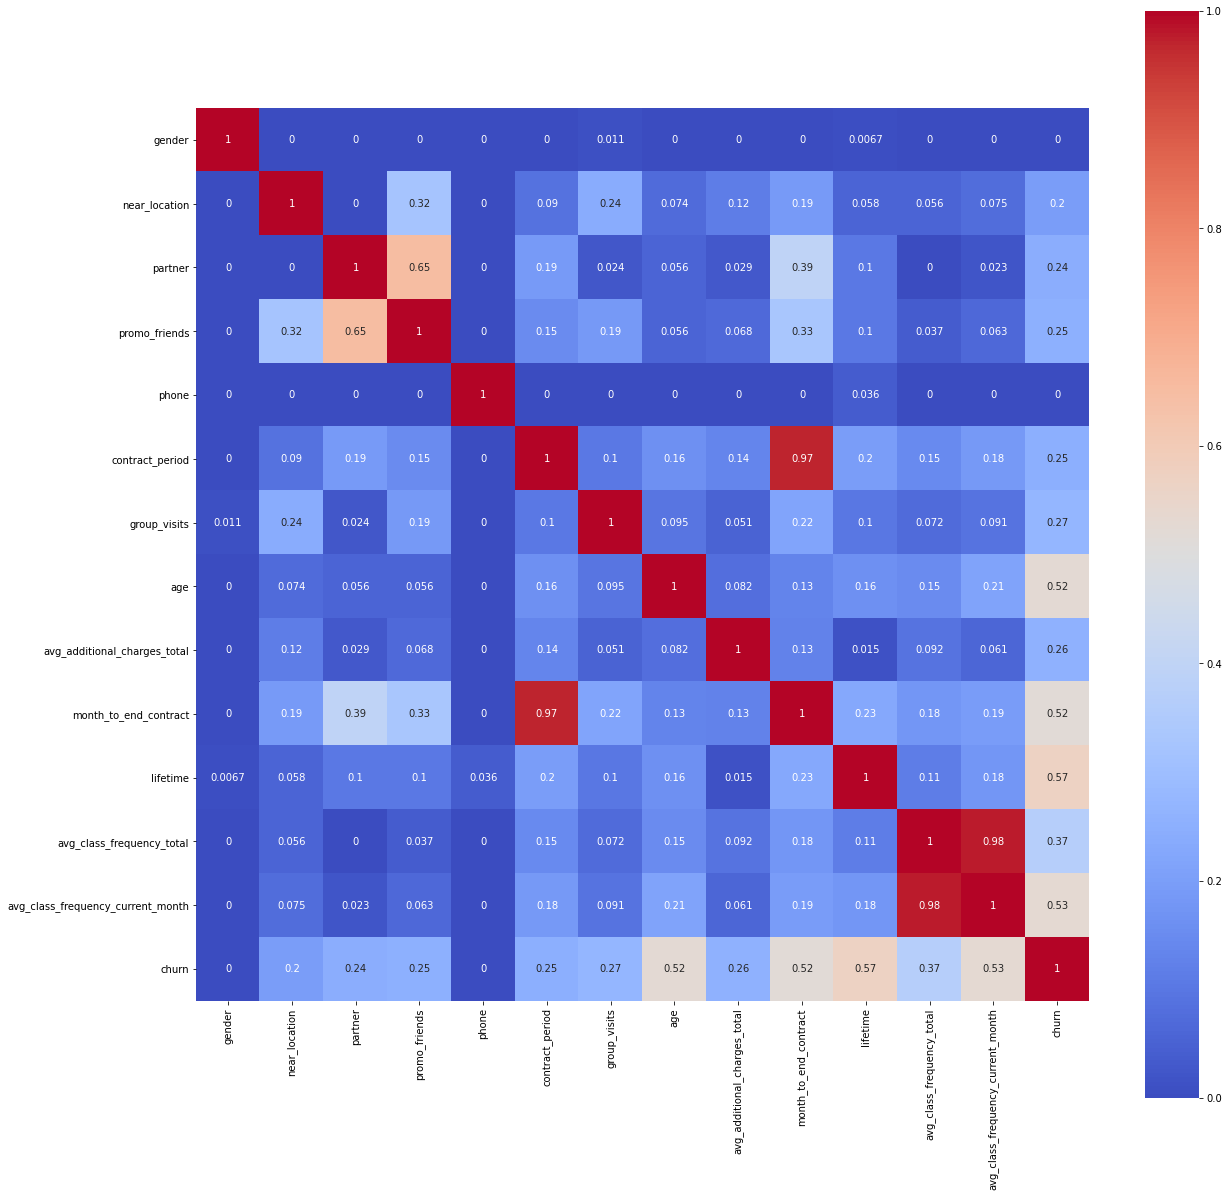

In [11]:
# построим матрицу корреляции методом phik
df_corr_phik = df.phik_matrix()
#нарисуем тепловую карту с подписями для матрицы корреляций
plt.figure(figsize=(20, 20))
sns.heatmap (df_corr_phik, cmap='coolwarm', annot = True, square = True)

plt.show()

Между некоторыми параметрами наблюдается сильная корреляция:
- month_to_end_contract и contract_period - коэффициент корреляции составил 0,97
- avg_class_frequency_current_month и avg_class_frequency_total - коэффициент корреляции составил 0,98
    
    
Умеренная связь наблюдается между признаками promo_friends и partner, contract_period и partner
    
Дополнительно выявлена умеренная связь между параметрами partner и mounth_to_end_contract - коэффициент 0,39. Возможно для участников партнерской программы наиболее выгодными были абонименты с определенным сроком действия.
    
Между остальными параметрами связь слабая.
    
Также видно, что наибольшая сила связи с целевой переменной имеют параметры lifetime, avg_class_frequency_total, age, contract_period, month_to_end_contract. Судить о характере связи (прямая или обратная) в рамках данного метода нет возможности, т.к. величина коэффициента составляет от 0 до 1 и расчитывается на основе квадратов значений.

Удалим по одному столбцу из пар коррелирующих признаков, чтобы избежать эффекта мультиколлениарности.

</div>

In [12]:
# удаляем коррелирующие призкани
df = df.drop(['month_to_end_contract', 'avg_class_frequency_current_month'], axis = 1)


In [13]:
#проверим результат удаления
display(df.head())
df.shape

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0


(4000, 12)

**Краткий вывод по разделу:**
    
В данном разделе проведен исследовательский анализ данных.
Были преобразованы наименования столбцов датафрейма - приведены к строчному написанию.
Выбросы для данных значений не неблюдается.    
    
Были выявлены признаки, которые наиболее сильно изменяются при изменении признака оттока. Это: lifetime, contract_period, month_to_end_contract. Эти признаки могут быть наиболее полезными при решении задачи прогнозтрования оттока клиентов.

Также было рассмотрено изменение распределения признаков при различном значении оттока. В теле раздела дана характеристика распределений.

В рамках подготовки можели в использованию методов машинного обучения - выявлены признаки, имеющие сльную корреляцию. Удалены по одному признаку из пар взаимно коррелирующих признаков.


## Выбор модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:


In [14]:
# разделим датафрейм на признаки и целевую переменную
X = df.drop ('churn', axis = 1)
y = df['churn']

In [15]:
# стандартизируем значения признаков и проверим результат
scaler = preprocessing.StandardScaler()
X_sc = scaler.fit_transform (X)
X_sc

array([[ 0.97970588,  0.42788074,  1.02686062, ..., -1.37753121,
        -0.19332863, -1.91191971],
       [-1.0207145 ,  0.42788074, -0.973842  , ..., -0.35021325,
         0.87368001,  0.04517569],
       [-1.0207145 ,  0.42788074,  1.02686062, ..., -0.1815923 ,
        -0.46008079, -0.02049263],
       ...,
       [ 0.97970588,  0.42788074,  1.02686062, ..., -0.71300239,
        -0.46008079,  0.93313947],
       [-1.0207145 ,  0.42788074,  1.02686062, ..., -0.88258181,
        -0.19332863, -0.25604937],
       [ 0.97970588, -2.33709981,  1.02686062, ...,  0.33129445,
        -0.72683295, -0.79947418]])

In [16]:
#разделим выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size = 0.2, random_state = 0,  stratify=y)

In [17]:
model_LR = LogisticRegression(random_state=0) 
model_LR.fit(X_train, y_train)
y_pred = model_LR.predict(X_test) 
y_probas = model_LR.predict_proba(X_test) 

Оценим метрики accuracy, precision и recall для модели LogisticRegression(random_state=0) на валидационной выборке.

In [18]:
print('Accuracy of LogisticRegression model: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision of LogisticRegression model: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall of LogisticRegression model: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 of LogisticRegression model: {:.2f}'.format(f1_score(y_test, y_pred)))

Accuracy of LogisticRegression model: 0.91
Precision of LogisticRegression model: 0.83
Recall of LogisticRegression model: 0.83
F1 of LogisticRegression model: 0.83


Алгоритм логистической регрессии показал достаточно точный результат - accuracy, т.е. доля верных ответов составила 91%

Точность ответов, т.е. доля верных позитивных ответов, среди всех позитивных ответов составила - 83%

Полнота, т.е. доля выявленных положительных ответов составила 83%

F1 - мера составила 0,83 

In [19]:
model_RFR = RandomForestClassifier(random_state=0) 
model_RFR.fit(X_train, y_train)
y_pred = model_RFR.predict(X_test)

In [20]:
print('Accuracy of RandomForestClassifier model: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision of RandomForestClassifier model: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall of RandomForestClassifier model: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1 of RandomForestClassifier model: {:.2f}'.format(f1_score(y_test, y_pred)))

Accuracy of RandomForestClassifier model: 0.89
Precision of RandomForestClassifier model: 0.81
Recall of RandomForestClassifier model: 0.79
F1 of RandomForestClassifier model: 0.80


Метод случайного леса в данном случае оказался менее эффективным:
Accurency составил 89%
Точность - 81%, Полнота - 79%. F1 - мера 0,80.


## Кластеризацию клиентов

In [21]:
# подготовим данные для кластеризации: удалим столбец churn и стандартизируем данные.
X_class = data.drop('churn', axis = 1)
X_sc_class = scaler.fit_transform (X_class)

In [22]:
# выполним кластеризацию методом linkage()
linked = linkage(X_sc_class, method = 'ward') 

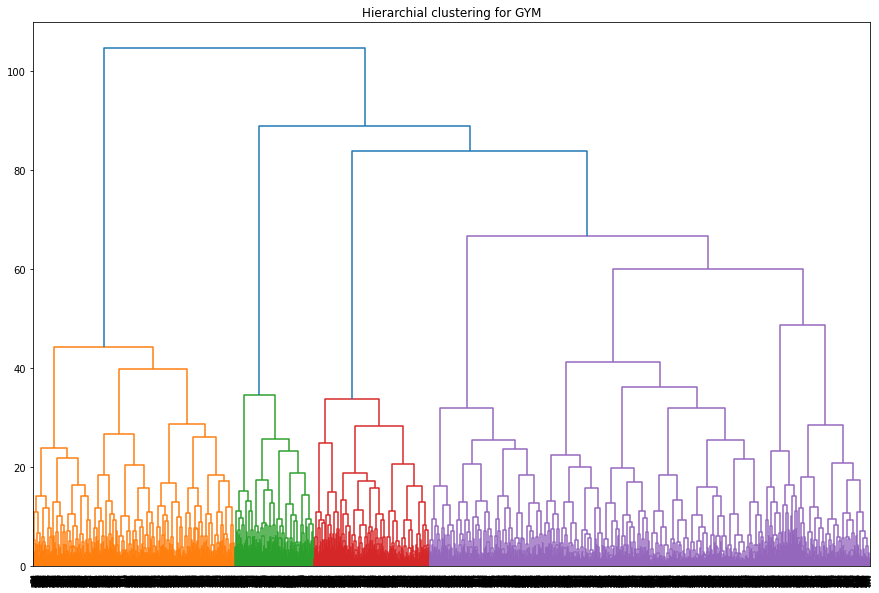

In [23]:
# выведем полученную дендрограмму 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

Предложенное оптимальное число кластеров 4 — четыре разных цвета на графике.

In [24]:
# обучим модель методом K-Means. ЧИсло кластеров - 5

km = KMeans(n_clusters=5, random_state=0) 
labels = km.fit_predict(X_sc_class)



In [25]:
# добавим принадлежность к группам в исходный датасет
data ['group'] = labels
data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,group
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,1
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,3
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,3


In [26]:
# посчитаем средние значения признаков внутри групп
km_pivot = data.groupby ('group').agg('mean').round(2).reset_index()
km_pivot = km_pivot.T

km_pivot

,0,1,2,3,4
group,0.00,1.00,2.00,3.00,4.00
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66


In [27]:
# таблица с использованием подсветки
cluster_features = data.groupby('group').mean().reset_index()
numeric_columns = cluster_features.drop(columns=['group']).columns
cluster_features.style.format({i: '{:.2f}' for i in numeric_columns}) \
    .highlight_max(color='yellowgreen', subset=numeric_columns) \
    .highlight_min(color='coral', subset=numeric_columns)
cluster_features.T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

,0,1,2,3,4
group,0.00,1.00,2.00,3.00,4.00
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66


In [28]:
# проверим численность различных класеров
pivot_by_cluster = data.pivot_table(index = 'group', values = 'churn', aggfunc = 'count')
pivot_by_cluster
pivot_by_cluster ['Доля пользователей, %'] = pivot_by_cluster['churn']/data['churn'].count() * 100
pivot_by_cluster.rename(columns = {'churn': 'Количество пользователей в кластере'})


,Количество пользователей в кластере,"Доля пользователей, %"
group,,
0,1010,25.250
1,385,9.625
2,505,12.625
3,1262,31.550
4,838,20.950


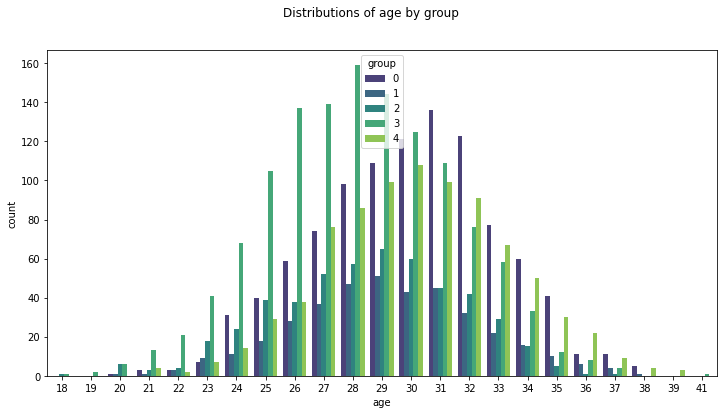

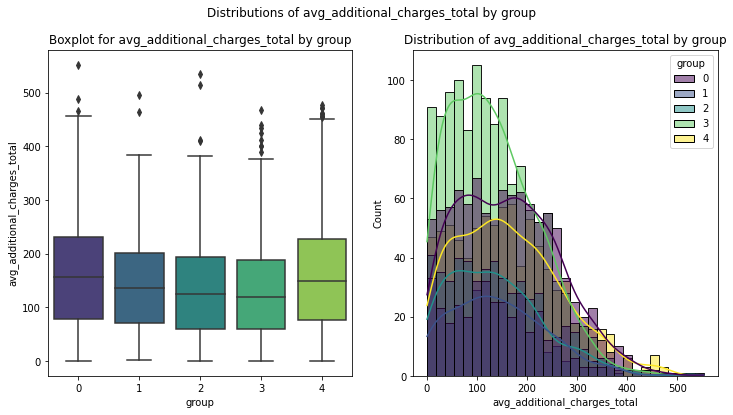

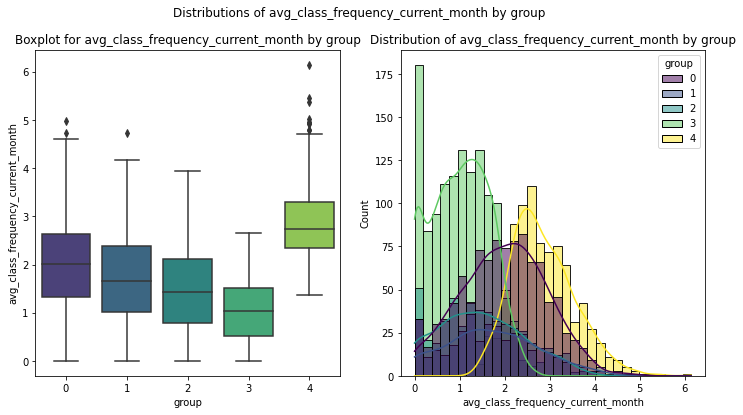

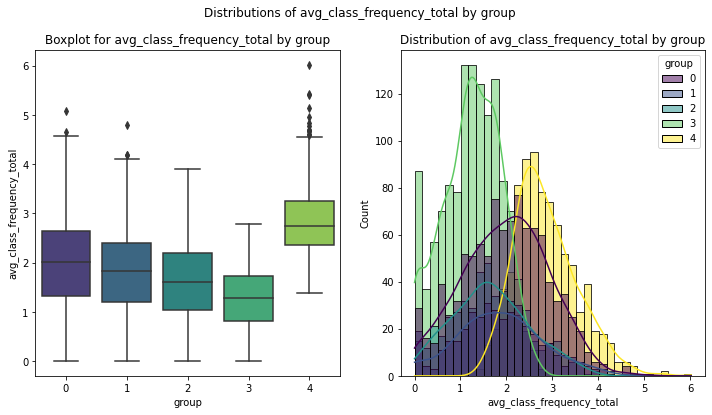

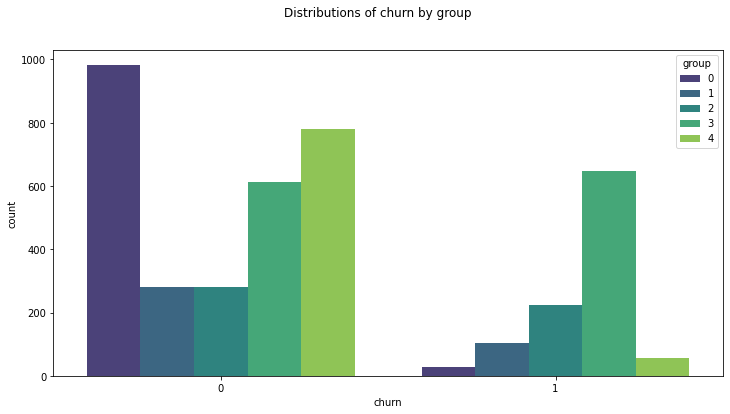

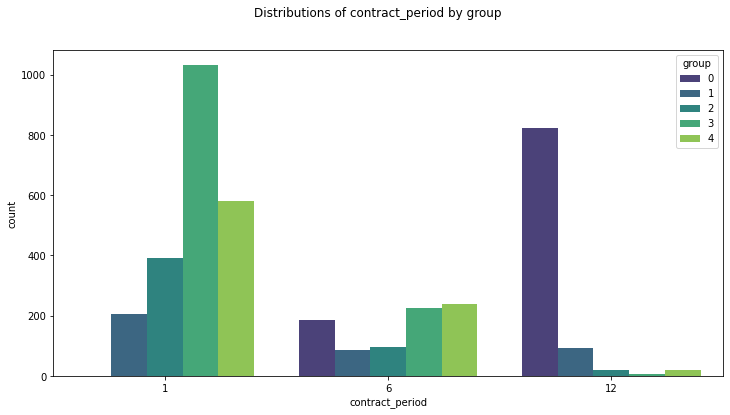

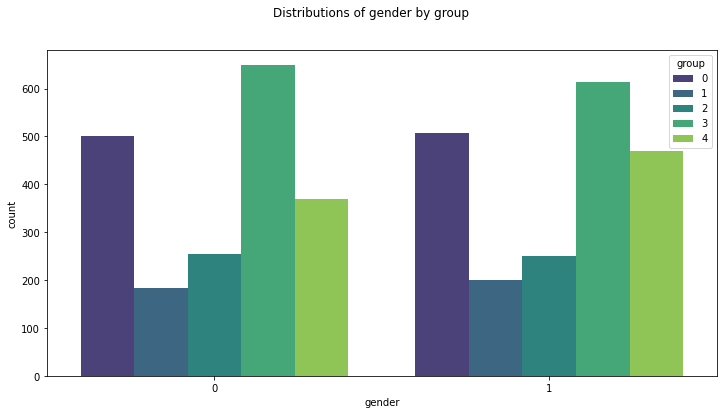

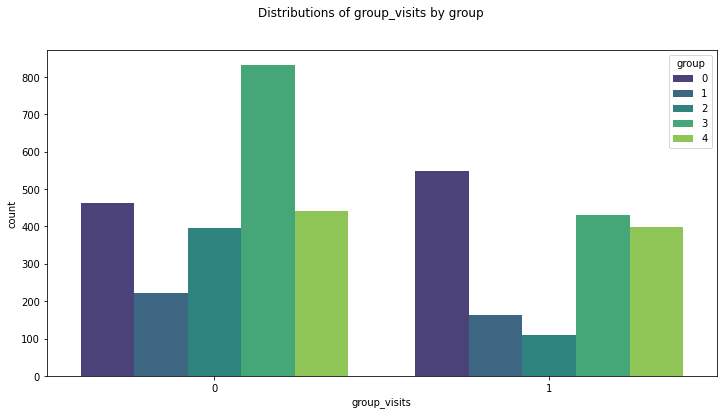

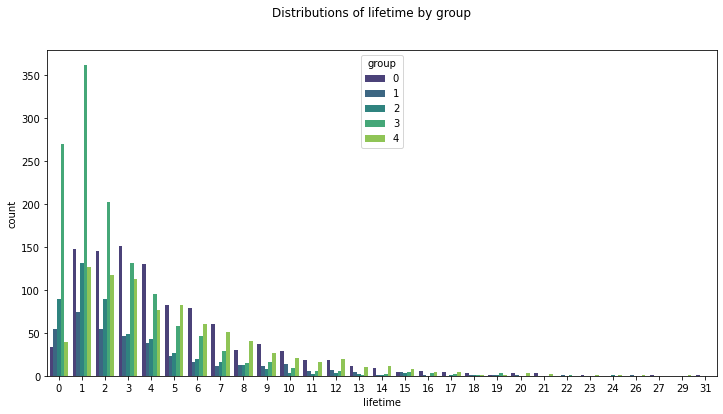

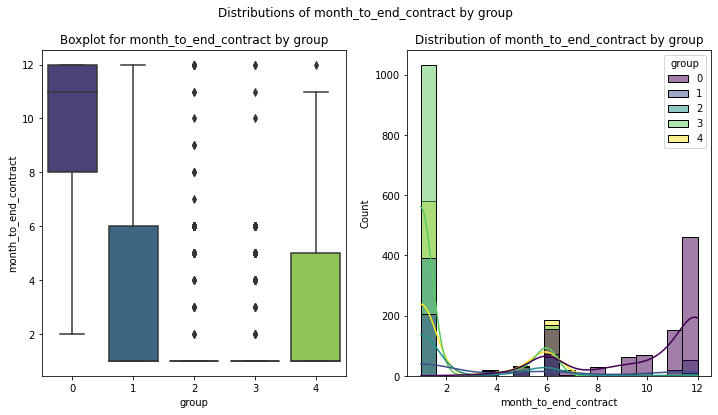

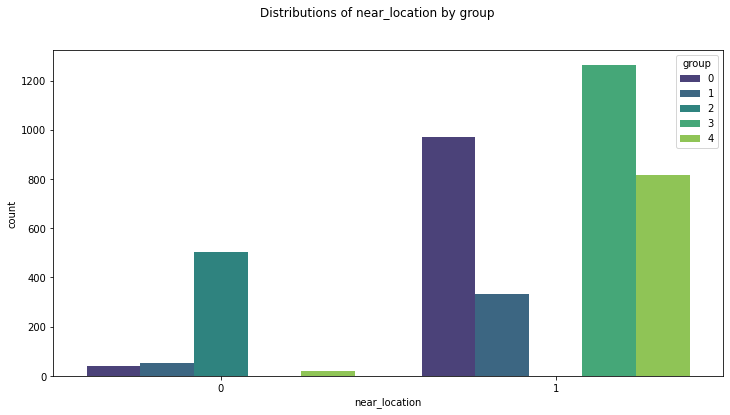

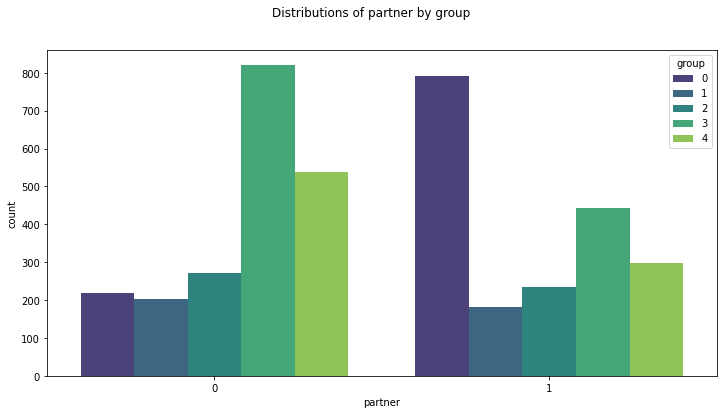

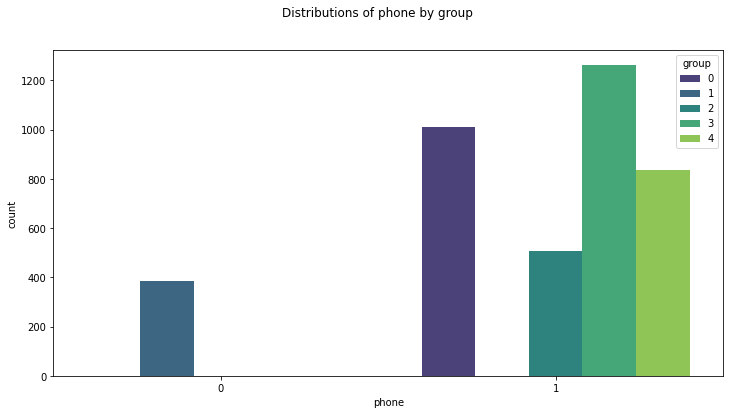

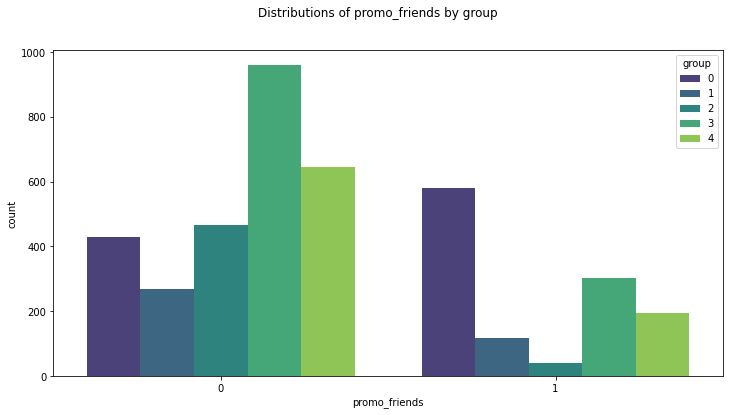

In [29]:
def plot_distributions(df):
    # Получим список признаков, исключив 'group'
    features_to_plot = df.columns.difference(['group'])
    
    for feature in features_to_plot:
        plt.figure(figsize=(12, 6))

        # Определение типа признака
        if df[feature].dtype in ['int64', 'int32']:
            # Для int и int32 используем countplot
            sns.countplot(data=df, x=feature, hue='group', palette='viridis')
        elif df[feature].dtype == float:
            # Для float используем boxplot и гистограмму
            plt.subplot(1, 2, 1)
            sns.boxplot(data=df, x='group', y=feature, palette='viridis')
            plt.title(f'Boxplot for {feature} by group')

            plt.subplot(1, 2, 2)
            sns.histplot(data=df, x=feature, hue='group', kde=True, palette='viridis')
            plt.title(f'Distribution of {feature} by group')

        plt.suptitle(f'Distributions of {feature} by group')
        plt.show()

# Пример вызова функции
plot_distributions(data)

В результате проведенной кластеризации клиенты были разделены на 5 кластеров.
На основании полученных средних значений признаков внутри каждого из кластеров, а также на основании графиков распределений признаков можно выделить основные отличия между кластерами.

**Кластер 0** 
- активные пользователи, не склонные к оттоку
- близко проживают/работают
- являются сотрудниками компании-партнёра клуба
- факт первоначальной записи в рамках акции «приведи друга» - более половины пользователей
- указали номер телефона
- длительный период действия договора до года
- часто посещают групповые занятия
- средний возраст около 30 лет
- высокие траты на дополнительные услуги
- длительный срок текущего абонимента
- lifetime более 4 месяцев
- в среднем около 2х посещений в неделю

**Кластер 1**
- пользователи со средней склонностию к оттоку
- близко проживают/работают
- признак сотрудника компании-партнёра клуба не является определяющим
- факт первоначальной записи в рамках акции «приведи друга» не является определяющим
- не указали номер телефона
- средний период действия договора
- часто посещают групповые занятия
- средний возраст около 30 лет
- средние траты на дополнительные услуги
- средний срок текущего абонимента
- lifetime более 3 месяцев
- 1-2 посещения в неделю

**Кластер 2**
- пользователи с высокой склонностью к оттоку
- проживают/работают далеко от фитнес-центра
- признак сотрудника компании-партнёра клуба не является определяющим
- не использовали первоначальную запись в рамках акции «приведи друга»
- указали номер телефона
- период действия договора короткий
- редко посещают групповые занятия
- средний возраст около 28 лет
- низкие траты на дополнительные услуги
- короткий срок текущего абонимента
- lifetime более 2 месяцев
- 1-2 посещения в неделю


**Кластер 3**
- пользователи с наиболее высокой склонностью к оттоку
- близко проживают/работают
- признак сотрудника компании-партнёра клуба не является определяющим
- факт первоначальной записи в рамках акции «приведи друга» не является определяющим
- указали номер телефона
- период действия договора короткий
- редко посещают групповые занятия
- средний возраст около 28 лет
- низкие траты на дополнительные услуги
- короткий срок текущего абонимента
- lifetime более 2 месяцев
- около 1 посещения в неделю

**Кластер 4**
- активные пользователи, не склонные к оттоку
- близко проживают/работают
- не являются сотрудниками компании-партнёра клуба
- факт первоначальной записи в рамках акции «приведи друга» не является определяющим
- указали номер телефона
- период действия договора короткий, либо средний
- часто посещают групповые занятия
- средний возраст около 30 лет
- высокие траты на дополнительные услуги
- короткий срок текущего абонимента
- lifetime более 4 месяцев
- в среднем более 2-х посещений в неделю

## Выводы и базовые рекомендации по работе с клиентами

Было проведено исследование оттка среди клиентов фитнес-цента.

В основе исследования - датасет, предоставленный со стороны заказчика.
Датасет содержит 4000 строк, без пропусков.
В качестве предобработки быдо выполнено преобразование названий столюбцов в строчный вид, других преобразований не потребовалось.

Основная работа включила два этапа:
    
1) Обучение моделей прогнозированию признака оттка в следующем месяце на основании имеющийся данных.
Для этого данные были дополнительно отчищены от коррелирующих признаков.
Обучены две модели - модель логистической регрессии и модель случайного леса.
Ниже приведены основные показатели эффективности данных моделей.
    
    Accuracy of LogisticRegression model: 0.91
    Precision of LogisticRegression model: 0.83
    Recall of LogisticRegression model: 0.83
    F1 of LogisticRegression model: 0.83
    
    Accuracy of RandomForestClassifier model: 0.89
    Precision of RandomForestClassifier model: 0.81
    Recall of RandomForestClassifier model: 0.79
    F1 of RandomForestClassifier model: 0.80
    
На основании данных показателей была выбрата модель логистической регресии регрессии, как наиболее эффективная.
    
2) Кластеризация клиентов. Выявлены группы с различным уровнем склонности к оттоку и описаны их характеристики.


В качестве основных выводов можно выделить:

    1) Наиболее стабильные группы пользователей имеют характеристики:
        - наличие длительного абонимента
        - проживание/работа в районе расположения центра
        - посещают групповые занятия
    2) Наименее стабильные группы, попадающие в отток:
        - покапают краткосрочные обонименты и не возвращаются за продлением
        - проживают/работают не далеко от района расположения центра.
        
Исходя из выделенных характеристик сформулированы рекомендации:

    1) Проведение активной рекламной кампании для жителей района присутствия центра
    2) Привлечение в качестве клиентов сотрудников компаний-партнеров центра, располагающихся рядом с центром.
    3) Проведение работы с клиентами-новичками, купившими "пробный краткосрочный абонимент". 
    Например формирование тарифных планов с сопровождением тренерами, консультантами по питанию и т.п., с целью облегчения формирования привычки к активным занятиям,.
    4) Т.к. для большинства клиентов указаны номера телефонов, возможно выполнение рассылки для клиентов, у которых прогнозируется отток в следующем месяце.
    Это может быть рассылка с промо-акциями на дополнительные услуги, мотивирующая/поддерживающая рассылка.
    
Данные мероприятия могут помочь сохранить клиентов, попадающих в нестабильные кластера.